In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.metrics import confusion_matrix

In [105]:
df = pd.read_csv("../data/lego.population.csv", sep = ",", encoding = "latin1")
df.head()
df

,Item_Number,Set_Name,Theme,Pieces,Price,Amazon_Price,Year,Ages,Pages,Minifigures,Packaging,Weight,Unique_Pieces,Availability,Size
0,41916,Extra Dots - Series 2,DOTS,109.0,$3.99,$3.44,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
1,41908,Extra Dots - Series 1,DOTS,109.0,$3.99,$3.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
2,11006,Creative Blue Bricks,Classic,52.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,28.0,Retail,Small
3,11007,Creative Green Bricks,Classic,60.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,36.0,Retail,Small
4,41901,Funky Animals Bracelet,DOTS,33.0,$4.99,$4.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,10.0,Retail,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,45678,SPIKE Prime Set,LEGO® Education,528.0,$329.95,NaN,2020,Ages_10+,NaN,2.0,NaN,NaN,108.0,NaN,Small
1300,71367,Mario's House & Yoshi,LEGO® Super Mario,205.0,$29.99,NaN,2020,Ages_6+,NaN,2.0,Box,NaN,114.0,Retail,Small
1301,71368,Toad's Treasure Hunt,LEGO® Super Mario,464.0,$69.99,NaN,2020,Ages_8+,NaN,4.0,Box,NaN,195.0,Retail,Small
1302,71369,Bowser's Castle Boss Battle,LEGO® Super Mario,1010.0,$99.99,NaN,2020,Ages_8+,NaN,NaN,Box,NaN,346.0,Retail,Small


In [112]:
# fjerner forklaringsvariabler vi ikke trenger
df2 = df[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Minifigures', 'Unique_Pieces']]

# fjerner observasjoner med manglende datapunkter (I virkeligheten er det risikabelt å fjerne manglende data punkter uten videre. Dette kan påvirke resultatene på en måte som er vanskelig å avdekke.)
# Det finnes metoder som tar hensyn til tomme dataceller men dette prosjektet har ikke dette som en del av oppgaven, slik at vi velger å ta utgangspunkt i det originale datasettet.
df2 = df2.dropna()

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str)
df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)

# og gjør så prisen om til float
df2['Price'] = df2['Price'].astype(float)

df2

df2['LegoGroup'] = np.where(df2['Theme'].isin(['Harry Potter', 'Star Wars', 'Batman', 'DC', 'Disney', 'Marvel', 'Minecraft', 'LEGO Frozen 2', 'Trolls World Tour', 'Minions', 'Powerpuff Girls', 'Jurassic World', 'Overwatch', 'Spider-Man', 'Stranger Things']), 0, 
                      np.where(df2['Theme'].isin(['City', 'Friends', 'Unikitty', 'NINJAGO', 'DUPLO', 'THE LEGO MOVIE 2', 'Speed Champions', 'Hidden Side', 'Classic', 'Juniors', 'Creator 3-in-1', 'Ideas', 'Creator Expert', 'Monkie Kid', 'Minifigures', 'Powered UP']), 1, 2))
df2.groupby(['LegoGroup']).size().reset_index(name = 'Count')

#df2['Age'] = np.where(df2['Ages'].isin(['Ages_10+', 'Ages_10+']), 10, np.where(df2['Ages'].isin(['Ages_6+']), 6, np.where(df2['Ages'].isin(['Ages_8+']), 8, 0)))
#df2.groupby(['LegoGroup']).size().reset_index(name = 'Count')

<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
C:\Users\vikto\AppData\Local\Temp\ipykernel_22204\2925582622.py:13: SyntaxWarning: invalid escape sequence '\$'
  df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)


,LegoGroup,Count
0,0,282
1,1,432


In [113]:
print(df2.head())

# Logistic regression model
formula = "LegoGroup ~ Price + Pieces + Pages + Minifigures + Unique_Pieces"
model = smf.logit(formula, data=df2)
result = model.fit()

# Display the summary
print(result.summary())

                        Set_Name    Theme  Pieces  Price  Pages  Minifigures  \
13  Stephanie's Summer Heart Box  Friends    95.0   7.99   40.0          1.0   
16                    Woody & RC   Disney    69.0   9.99   28.0          1.0   
17        Mia's Summer Heart Box  Friends    85.0   7.99   36.0          1.0   
18     Olivia's Summer Heart Box  Friends    93.0   7.99   40.0          2.0   
19             Police Patrol Car     City    92.0   9.99   36.0          1.0   

    Unique_Pieces  LegoGroup  
13           52.0          1  
16           36.0          0  
17           41.0          1  
18           48.0          1  
19           52.0          1  
Optimization terminated successfully.
         Current function value: 0.645277
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              LegoGroup   No. Observations:                  714
Model:                          Logit   Df Residuals:                    

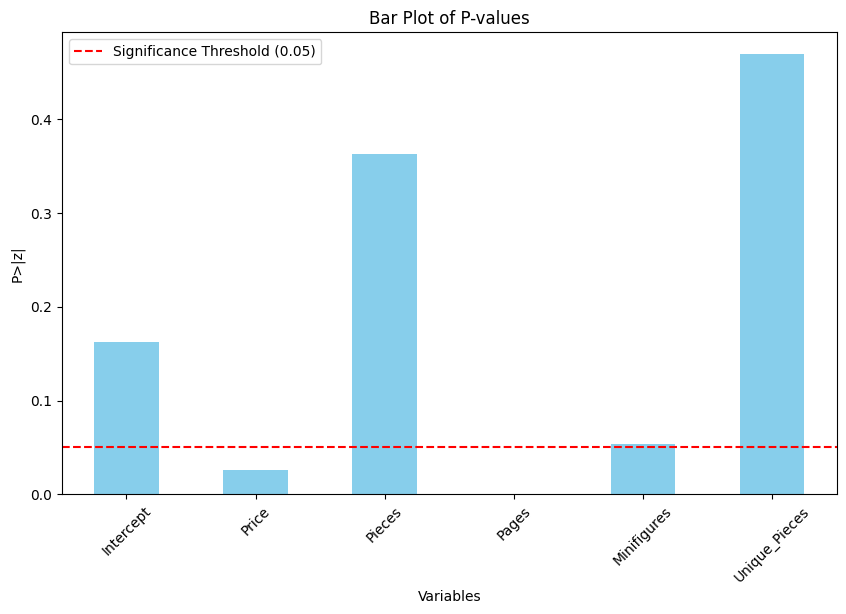

In [114]:
p_values = result.pvalues

# Create a bar plot for p-values
plt.figure(figsize=(10, 6))
p_values.plot(kind='bar', color='skyblue')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.xlabel('Variables')
plt.ylabel('P>|z|')
plt.title('Bar Plot of P-values')
plt.xticks(rotation=45)
plt.legend()
plt.show()

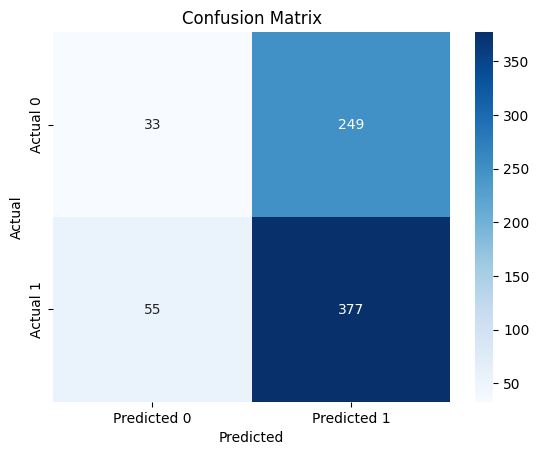

In [115]:
predictions = result.predict(df2)

actual_values = df2['LegoGroup']

# Set the threshold
threshold = 0.5

# Create binary predictions based on the threshold
binary_predictions = (predictions >= threshold).astype(int)

# Create a confusion matrix
conf_matrix = confusion_matrix(actual_values, binary_predictions)

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [125]:
# Logistic regression model (new model)
formula = "LegoGroup ~ Price + Pages + Minifigures"
model = smf.logit(formula, data=df2)
result = model.fit()

# Display the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.645999
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              LegoGroup   No. Observations:                  714
Model:                          Logit   Df Residuals:                      710
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                 0.03714
Time:                        13:06:29   Log-Likelihood:                -461.24
converged:                       True   LL-Null:                       -479.03
Covariance Type:            nonrobust   LLR p-value:                 9.189e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2851      0.139      2.053      0.040       0.013       0.557
Price          -0.0128    

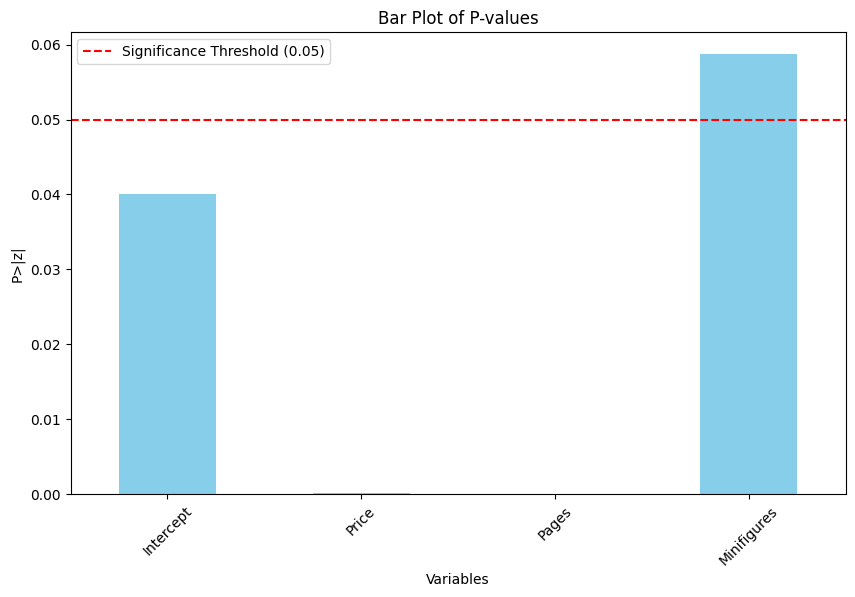

In [126]:
p_values = result.pvalues

# Create a bar plot for p-values
plt.figure(figsize=(10, 6))
p_values.plot(kind='bar', color='skyblue')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.xlabel('Variables')
plt.ylabel('P>|z|')
plt.title('Bar Plot of P-values')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [127]:
formel = 'Price ~ LegoGroup + Pages + Minifigures'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     441.7
Date:                Fri, 10 Nov 2023   Prob (F-statistic):          7.58e-162
Time:                        13:08:00   Log-Likelihood:                -3477.6
No. Observations:                 714   AIC:                             6963.
Df Residuals:                     710   BIC:                             6981.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.7013      2.509     -1.077      0.282      -7.627       2.224
LegoGroup     -10.3878      2.448     -4.243      0.000     -15.195      -5.581
Pages           0.4303      0.017     25.426      0.000       0.397       0.463
Minifigures     3.3921      0.597      5.686      0.000       2.221       4.563
==============================================================================
Omnibus:                      933.825   Durbin-Watson:                   1.483
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           265008.827
Skew:                           6.437   Prob(JB):                         0.00
Kurtosis:                      96.499   Cond. No.                         358.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

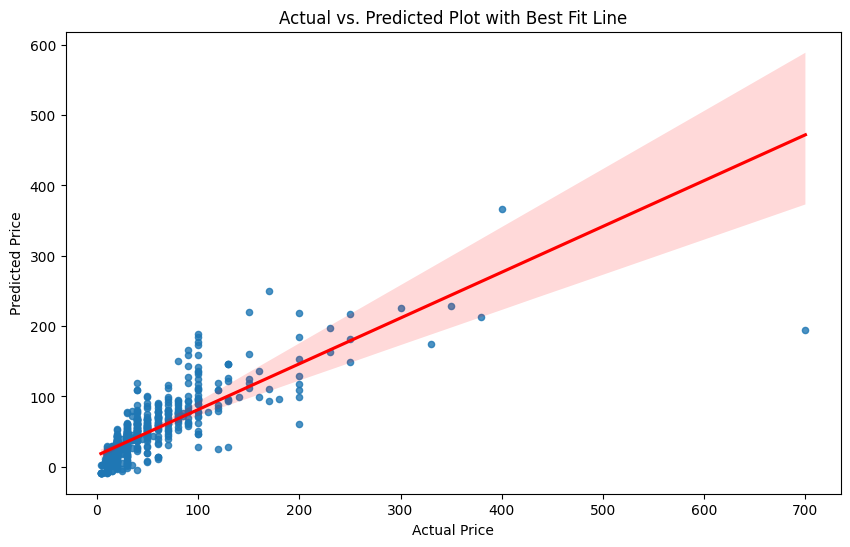

In [135]:
predicted_values = resultat.predict()

# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x=df2['Price'], y=predicted_values, scatter_kws={'s': 20}, line_kws={'color': 'red'}, ci = 95)
plt.title('Actual vs. Predicted Plot with Best Fit Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

# Tester noen visualiseringer av dataen

In [118]:
formel = 'Price ~ LegoGroup + Pages + Minifigures'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     441.7
Date:                Fri, 10 Nov 2023   Prob (F-statistic):          7.58e-162
Time:                        13:02:03   Log-Likelihood:                -3477.6
No. Observations:                 714   AIC:                             6963.
Df Residuals:                     710   BIC:                             6981.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.7013      2.509     -1.077      0.282      -7.627       2.224
LegoGroup     -10.3878      2.448     -4.243      0.000     -15.195      -5.581
Pages           0.4303      0.017     25.426      0.000       0.397       0.463
Minifigures     3.3921      0.597      5.686      0.000       2.221       4.563
==============================================================================
Omnibus:                      933.825   Durbin-Watson:                   1.483
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           265008.827
Skew:                           6.437   Prob(JB):                         0.00
Kurtosis:                      96.499   Cond. No.                         358.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

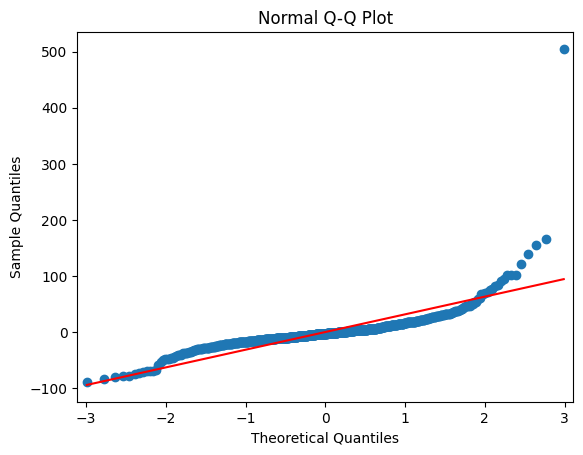

In [119]:
# Normal Q-Q plot
sm.qqplot(resultat.resid, line='s')  # 's' gir en referanselinje for standard normal distribusjon
plt.title('Normal Q-Q Plot')
plt.show()

C:\Users\vikto\AppData\Local\Temp\ipykernel_22204\3568732884.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Koeffisient', y=resultat_df.index, data=resultat_df, ci=None, palette='viridis')
C:\Users\vikto\AppData\Local\Temp\ipykernel_22204\3568732884.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Koeffisient', y=resultat_df.index, data=resultat_df, ci=None, palette='viridis')


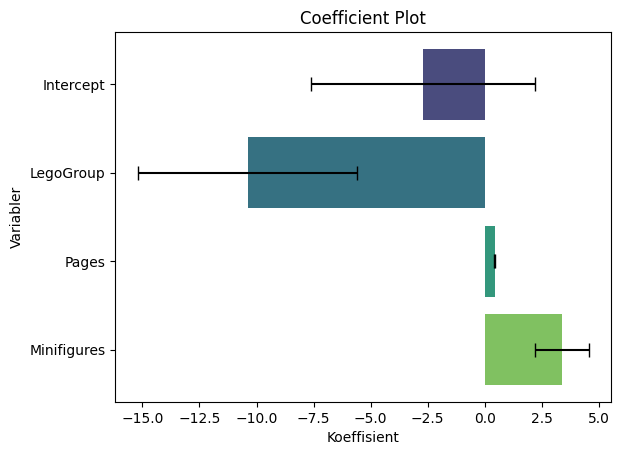

In [120]:
koeffisienter = resultat.params
konfidensintervaller = resultat.conf_int()

# Lag en DataFrame for enklere plotting
resultat_df = pd.DataFrame({'Koeffisient': koeffisienter, 'Lower CI': konfidensintervaller[0], 'Upper CI': konfidensintervaller[1]})

# Plot koeffisientene med konfidensintervallene
sns.barplot(x='Koeffisient', y=resultat_df.index, data=resultat_df, ci=None, palette='viridis')
plt.errorbar(x=resultat_df['Koeffisient'], y=resultat_df.index, xerr=[resultat_df['Koeffisient'] - resultat_df['Lower CI'], resultat_df['Upper CI'] - resultat_df['Koeffisient']], fmt='none', color='black', capsize=5)
plt.title('Coefficient Plot')
plt.xlabel('Koeffisient')
plt.ylabel('Variabler')
plt.show()

c:\Users\vikto\anaconda3\envs\venv\Lib\site-packages\statsmodels\graphics\regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)
c:\Users\vikto\anaconda3\envs\venv\Lib\site-packages\statsmodels\graphics\regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)
c:\Users\vikto\anaconda3\envs\venv\Lib\site-packages\statsmodels\graphics\regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will

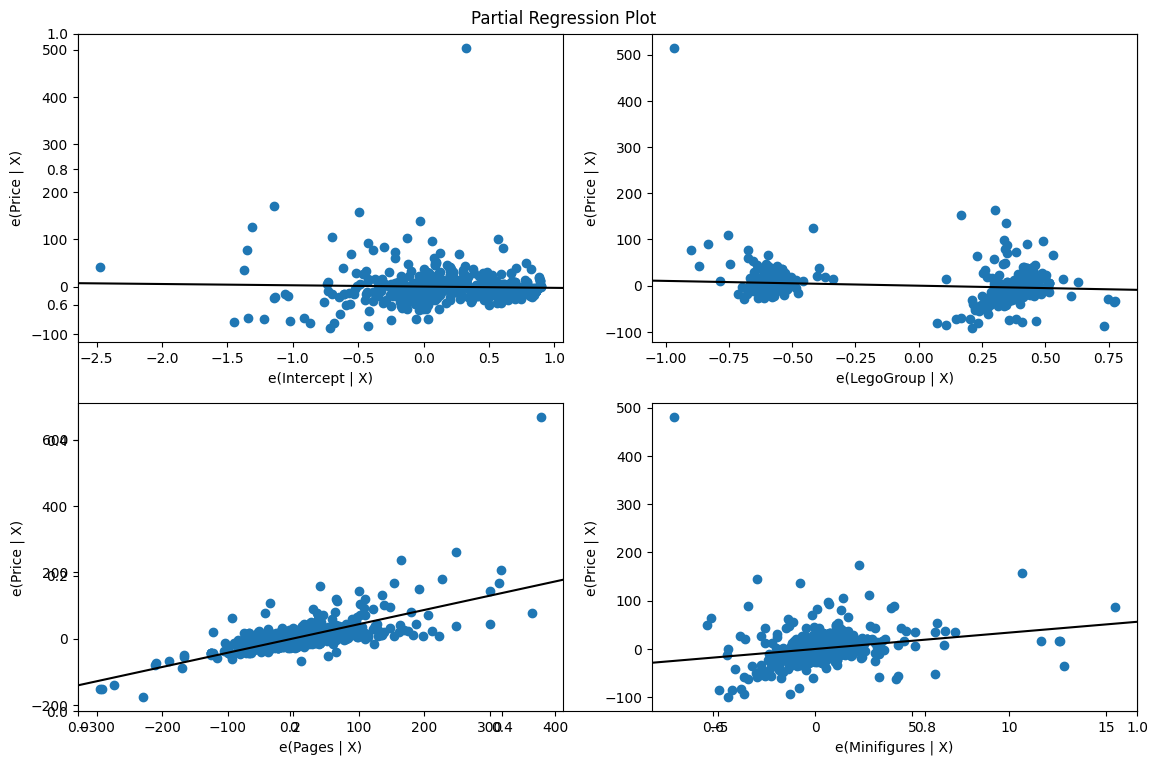

In [121]:
from statsmodels.graphics.regressionplots import plot_partregress_grid
fig, ax = plt.subplots(figsize=(12, 8))
plot_partregress_grid(resultat, fig=fig)
plt.suptitle('Partial Regression Plot')
plt.show()

# Tester klynge analyse 

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Assuming df2 is your DataFrame
# Define the features and target variable
X = df2[['Price', 'Pieces', 'Pages', 'Minifigures', 'Unique_Pieces']]
y = df2['LegoGroup']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but recommended for k-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Choose the number of neighbors (k)
k = 2
# Create a k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test_scaled)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_rep)

Accuracy: 0.5944
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.74      0.57        53
           1       0.77      0.51      0.61        90

    accuracy                           0.59       143
   macro avg       0.62      0.62      0.59       143
weighted avg       0.66      0.59      0.60       143



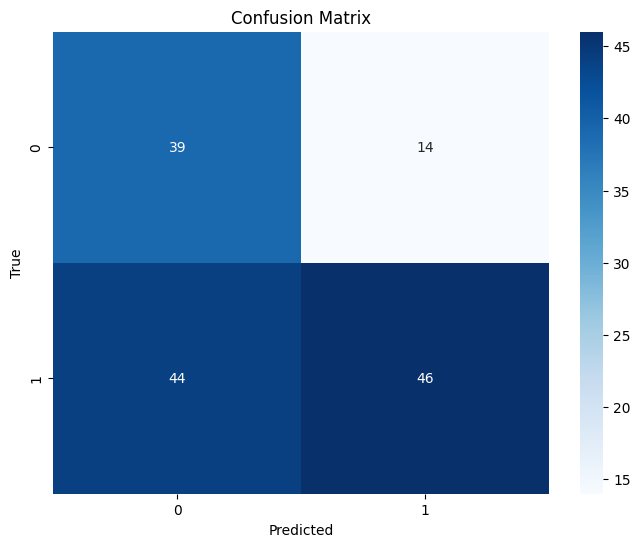

In [123]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=knn_classifier.classes_,
            yticklabels=knn_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()